In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import pickle
import sbi.utils as utils
import torch
from sbi.inference import MCMCPosterior
from scipy.special import logsumexp

# Get Overall Posterior
## $P(\theta|X_{1},...X_{n}) = $ $ {{P(\theta)}^{1-n}\Pi_{i}[P(\theta|X_{i})]} \over {\int{{P(\theta)}^{1-n}}\Pi_{i}[P(\theta|X_{i})]d\theta}$

In [20]:
# Get grid of log posterior values for x (observation)
def get_grid(posterior, x, n):
    # Explored space
    s = np.linspace(prior_min[0], prior_max[0], n)
    m = np.linspace(prior_min[1], prior_max[1], n)
    p = np.linspace(prior_min[2], prior_max[2], n)
    
    # Change to MCMC posterior to sample more efficiently
    potential_fn = posterior.potential_fn
    potential_fn.set_x(x)
    posterior_mcmc = MCMCPosterior(potential_fn, proposal = prior)
    
    # Create empty grid
    grd = np.array([[[[s_,m_,p_,0] for s_ in s] for m_ in m] for p_ in p]).reshape(n**3,4)
    # Fill it with posterior probability (potential = log_prob for MCMC posterior)
    grd[:,3] = posterior_mcmc.potential(x=x,theta=torch.tensor(grd[:,0:3],dtype=torch.float32))
    return grd
    
# Estimating Overall Posterior for many observations
def get_overall_posterior(prior,posterior,line,n):
    x = pd.read_csv(f'empirical_data/clean/{line}.csv', index_col=0)
    r = len(x)
    
    # get probs for first
    rim = get_grid(posterior, x.iloc[0,:], n)
    prod_df = pd.DataFrame(columns = ['log_s','log_m','log_p'] + list(x.index)+['sum_logs'], index=[i for i in range(len(rim))])
    prod_df.iloc[:,0:3] = rim[:,0:3]
    prod_df.iloc[:,3] = rim[:,3]
    # insert other replicates to df
    for i in range(1,len(x)):
        x_0 = x.iloc[i,:]
        prod_df.iloc[:,3+i] = get_grid(posterior,x_0,n)[:,3]
    # Column of sum of log-posteriors
    prod_df.loc[:,'sum_logs'] = prod_df.loc[:,list(x.index)].sum(axis=1)
    
    # Calculate constants for the integral
    lens = np.array([float(prior.base_dist.high[i])-float(prior.base_dist.low[i]) for i in range(3)]) # Prior dimensions
    A = np.prod(lens) # Prior volume
    dt = A / (n_**3) # granularity

    # Obtain C using integral (approximated by Riemann sum)

    # log(integrand) = log(product of posteriors * prior^(1-n) * dt)
    prod_df['adj_sum_logs'] = prod_df['sum_logs'] + np.log(dt) + np.log((1/A)**(1-r))

    # Riemann sum (minus -> inverse)
    log_C = -1*logsumexp(prod_df['adj_sum_logs'])

    # Overall Posterior
    prod_df['log_overall_posterior'] = prod_df['sum_logs']+np.log((1/A)**(1-r))+log_C

    # Dump to csv
    # prod_df.to_csv(f'overall_posteriors/{line}_overall_posterior.csv')
    
    return prod_df


In [24]:
%%time

prior_min = np.log10(np.array([1e-2,1e-7,1e-8]))
prior_max = np.log10(np.array([1,0.5,1e-2]))
prior = utils.BoxUniform(low=torch.tensor(prior_min), 
                         high=torch.tensor(prior_max))
n_ = 200
posterior = pickle.load(open(f'posteriors/posterior_chuong.pkl', 'rb'))
prod_df = get_overall_posterior(prior,posterior,'wt',n_)

CPU times: user 10min 25s, sys: 9min 9s, total: 19min 35s
Wall time: 1min 28s


Text(0, 0.5, 'Density')

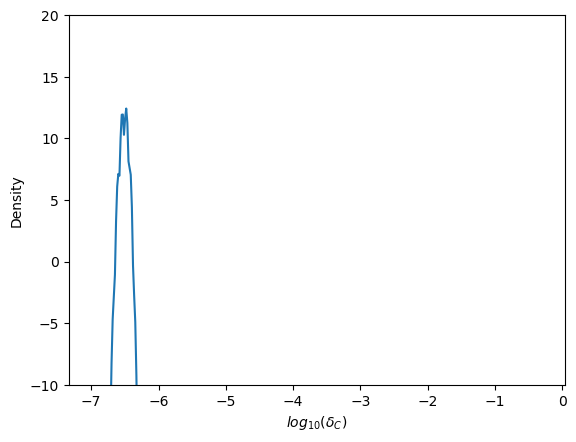

In [9]:
# Marginal posterior of mutation rate - all
# Using a pre-saved grid of n=400
prod_df = pd.read_csv('overall_posteriors/all_overall_posterior.csv', index_col=0)
marg_m = prod_df.groupby('log_m')['log_overall_posterior'].apply(lambda x: logsumexp(x))
plt.plot(prod_df['log_m'].unique(),marg_m)
plt.ylim(-10,20)
plt.xlabel('$log_{10}({δ_C})$')
plt.ylabel('Density')

# Overall Posterior Predictive Checks
## Simulate Overall Posterior MAP and compare to empirical observations

(-0.05, 1.05)

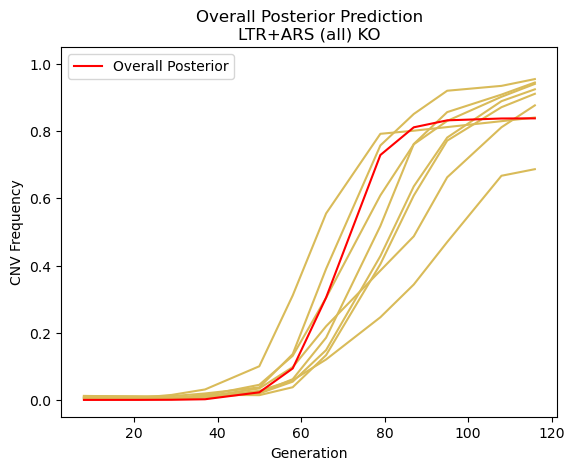

In [11]:
from cnv_simulation_initial_beneficial import CNVsimulator_simpleWF

# Model (simulator)
reps = 1
generation = pd.read_csv('Chuong_116_gens.txt', delimiter = ', ', engine='python')
generation = generation.columns.astype('int')
N = 3.3e8

def CNVsimulator(cnv_params):
    cnv_params = np.asarray(torch.squeeze(cnv_params,0))
    states = CNVsimulator_simpleWF(reps = reps, N=N, generation=generation, seed=73, parameters=cnv_params)
    return states

# Plot Overall Posterior prediction for WT
# Get data
wt_df = pd.read_csv(f'empirical_data/clean/all.csv', index_col=0)
for i in range(len(wt_df)):
    plt.plot(generation.tolist(), wt_df.iloc[i,:], color="#D9BB59")

# Overall MAP
overall_map = prod_df.iloc[prod_df['log_overall_posterior'].idxmax(), 0:3]
params = torch.tensor(list(overall_map), dtype=torch.float64)
x = CNVsimulator(params).T
plt.plot(generation.tolist(),x, label = 'Overall Posterior', color='red')

# Plotting
plt.legend()
plt.title('Overall Posterior Prediction\nLTR+ARS (all) KO')
plt.xlabel('Generation')
plt.ylabel('CNV Frequency')
# plt.title(f'log(s) = {float(params[0])}, log(δ) = {float(params[1])}')
plt.ylim(-0.05,1.05)